# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.


In [4]:
# === Insert & Save Project Overview (Markdown) — versi otomatis ===
from IPython.display import Markdown, display
from datetime import date
import os, math
import pandas as pd
import numpy as np

# >>> PARAMETER YANG BISA KAMU EDIT <<<
K_VAL = 10
TARGET_PREC_AT_K   = "≥ 0.25"
TARGET_RECALL_AT_K = "≥ 0.20"
TARGET_MAP_AT_K    = "≥ 0.15"

ARTICLES_PATH     = "/content/articles.csv"
INTERACTIONS_PATH = "/content/interactions.csv"

# --- Kumpulkan ringkasan dataset (jika file tersedia) ---
dataset_summary = ""
data_source_auto = "- (Belum terdeteksi — file CSV belum ditemukan)"
try:
    if os.path.exists(ARTICLES_PATH) and os.path.exists(INTERACTIONS_PATH):
        items = pd.read_csv(ARTICLES_PATH)
        inter = pd.read_csv(INTERACTIONS_PATH)

        # Tentukan skema kolom minimal
        col_item   = "article_id" if "article_id" in items.columns else items.columns[0]
        col_user   = "user_id"    if "user_id" in inter.columns else inter.columns[0]
        col_score  = "interaction" if "interaction" in inter.columns else inter.columns[-1]

        n_users = inter[col_user].nunique()
        n_items = items[col_item].nunique()
        n_inter = len(inter)
        density = n_inter / max(n_users * n_items, 1)

        # Deteksi sumber: MIND-small (user_id string 'U...') vs AG News sintetis (user_id int)
        if inter[col_user].dtype == object:
            data_source_auto = "- **MIND-small (Microsoft News)** — interaksi klik asli (user_id bertipe string)"
        else:
            data_source_auto = "- **ArticleCBF-mini (AG News + interaksi sintetis)** — user_id numerik"

        dataset_summary = (
            f"**Ringkasan dataset (otomatis):**\n\n"
            f"- #Users: **{n_users}**\n"
            f"- #Items: **{n_items}**\n"
            f"- #Interaksi: **{n_inter}**\n"
            f"- Sparsity (≈ interaksi / (users×items)): **{density:.6e}**\n"
        )
    else:
        dataset_summary = "_(File `articles.csv` / `interactions.csv` belum ditemukan; ringkasan akan muncul setelah file ada.)_"
except Exception as e:
    dataset_summary = f"_(Gagal membaca ringkasan dataset: {e})_"

# --- Susun Markdown (pakai raw string agar LaTeX aman) ---
project_overview_md = rf"""
# **Project Overview – Rekomendasi Artikel**

**Latar belakang.** Volume artikel/news yang sangat besar membuat pengguna kesulitan menemukan bacaan yang relevan. Sistem rekomendasi dibutuhkan untuk meningkatkan keterlibatan (*click-through rate*/CTR, *dwell time*) dan retensi pembaca.

**Tujuan bisnis.**
1) Meningkatkan CTR dan *dwell time*.
2) Menurunkan *bounce rate* di halaman artikel.
3) Mendorong konsumsi konten lintas kategori prioritas.

**Problem statement.**
Bagaimana memberikan **Top-N rekomendasi artikel personal** yang relevan bagi setiap pengguna berdasarkan riwayat interaksi/klik dan kemiripan konten artikel?

**Goals.**
- Menghasilkan **Top-{K_VAL}** rekomendasi untuk setiap pengguna.
- Mencapai **Precision@{K_VAL} {TARGET_PREC_AT_K}**, **Recall@{K_VAL} {TARGET_RECALL_AT_K}**, dan **MAP@{K_VAL} {TARGET_MAP_AT_K}** pada data validasi.
- Menyediakan **dua pendekatan** (Content-Based & Collaborative) serta membandingkan hasilnya.

---

## **Solution Approach**

**1) Content-Based Filtering (CBF)**
- Representasi artikel: TF-IDF (uni/bi-gram) pada *title + content* (opsional + kategori).
- Skor kemiripan: **cosine similarity** antar vektor konten.
- Personalisasi: *user profile* = agregasi (mean/weighted) vektor artikel yang pernah diklik → rekomendasikan artikel paling mirip, *exclude* yang sudah dibaca.

**2) Collaborative Filtering (CF)**
- **Implicit feedback**: klik/dwell sebagai sinyal (biner/berbobot).
- Algoritma: **Item–Item** (cosine dari ko-occurence) *(bisa dikembangkan ke ALS/BPR untuk lanjutan)*.
- Rekomendasi: skor \(\hat{{R}}_{{u,i}}\) dari model → ambil Top-N.

**Catatan implementasi.** Pipeline mencakup hold-out split, normalisasi skor, dan *cold-start fallback* (popularitas per kategori).

---

## **Metrik Evaluasi Top-N**

Untuk tiap user \(u\) dengan ground truth \(G_u\) dan rekomendasi berurutan \(R_u=[r_1,\dots,r_{K}]\):

**Precision@K (per user)**
\[
\mathrm{{Precision@K}}(u)=\frac{{|R_u@K \cap G_u|}}{{K}}
\]

**Recall@K (per user)**
\[
\mathrm{{Recall@K}}(u)=\frac{{|R_u@K \cap G_u|}}{{|G_u|}}
\]

**Average Precision@K (AP@K, per user)**
\[
\mathrm{{AP@K}}(u)=\frac{{1}}{{\min(|G_u|,K)}}\sum_{{k=1}}^{{K}} \mathrm{{Precision@}}k(u)\cdot \mathrm{{rel}}_u(k)
\]
dengan \(\mathrm{{rel}}_u(k)=1\) bila \(r_k \in G_u\), selain itu 0.

**MAP@K (rata-rata antar user)**
\[
\mathrm{{MAP@K}}=\frac{{1}}{{|U_{{\text{{eval}}}}|}}\sum_{{u\in U_{{\text{{eval}}}}}}\mathrm{{AP@K}}(u)
\]

(Opsional) **DCG@K / NDCG@K** untuk menilai kualitas urutan.

---

## **Exploratory Data Analysis (EDA) – Ringkasan Insight yang Diharapkan**
- **Distribusi kategori artikel** (cek imbalance).
- **Popularitas artikel** (long-tail).
- **Interaksi per pengguna** (sparsity tinggi → pentingnya regularisasi & *backfill*).
- **Korelasi konten** (klaster tematik via TF-IDF).
- **Cold-start**:
  - *Item cold-start* → CBF efektif (berbasis konten).
  - *User cold-start* → *trending/popular per kategori* + eksplorasi.

---

## **Data & Sumber**
{data_source_auto}

**Skema umum:**
- **articles.csv**: `article_id, title, content, category`
- **interactions.csv**: `user_id, article_id, interaction` (implicit)

{dataset_summary}

_Tanggal pembuatan:_ {date.today().isoformat()}
"""

# --- Tampilkan & simpan ---
display(Markdown(project_overview_md))

out_path = "/content/PROJECT_OVERVIEW.md"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(project_overview_md)

print(f"✅ Project Overview ditampilkan & disimpan ke {out_path}")


NameError: name 'K' is not defined

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [ ]:
#Type your code here

import os, re, json, math, gc, random, textwrap
import numpy as np
import pandas as pd

# Visualisasi
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)

# Preprocess & EDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [ ]:
# === Build dataset ArticleCBF-mini (AG News + synthetic interactions) ===
import pandas as pd, numpy as np

# 1) Ambil data berita (title & content) dari AG News (open source, no auth)
URL = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
df = pd.read_csv(URL, header=None, names=["label","title","content"])

# Mapping label -> kategori
label_map = {1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}
df["category"] = df["label"].map(label_map)
df["article_id"] = np.arange(1, len(df)+1)

# (opsional) ambil subset biar ringan
MAX_ARTICLES = 20000
articles = df.sample(n=min(MAX_ARTICLES, len(df)), random_state=42).reset_index(drop=True)
articles = articles[["article_id","title","content","category"]]

# 2) Sintesis interaksi user (implicit score 0..1)
N_USERS = 1000
rng = np.random.default_rng(42)
cats = articles["category"].unique().tolist()
cat_to_items = {c: articles.loc[articles["category"]==c, "article_id"].to_numpy() for c in cats}

rows = []
for u in range(1, N_USERS+1):
    pref = rng.dirichlet(np.ones(len(cats)))              # preferensi user ke tiap kategori
    n_int = rng.integers(15, 35)                          # banyak interaksi
    for _ in range(n_int):
        c = rng.choice(cats, p=pref)
        item = rng.choice(cat_to_items[c])
        score = 0.6 + 0.4*pref[cats.index(c)] + rng.normal(0,0.05)  # dwell-like score
        rows.append((u, int(item), float(np.clip(score, 0, 1))))

inter = pd.DataFrame(rows, columns=["user_id","article_id","interaction"])

# 3) Simpan
articles.to_csv("/content/articles.csv", index=False)
inter.to_csv("/content/interactions.csv", index=False)

print("Saved:", articles.shape, inter.shape)
display(articles.head(), inter.head())



Saved: (20000, 4) (24387, 3)


,article_id,title,content,category
0,71788,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...",Business
1,67219,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,Business
2,54067,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,Sports
3,7169,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,Sci/Tech
4,29619,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,Business


,user_id,article_id,interaction
0,1,12187,0.621506
1,1,108813,0.686168
2,1,13054,0.765086
3,1,79489,0.752195
4,1,4263,0.748308


In [ ]:
ARTICLES_CSV     = "/content/articles.csv"
INTERACTIONS_CSV = "/content/interactions.csv"
COL_ITEM_ID="article_id"; COL_TITLE="title"; COL_CONTENT="content"; COL_CAT="category"
COL_USER="user_id"; COL_SCORE="interaction"


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

Missing ratio items:


,missing_ratio
article_id,0.0
title,0.0
content,0.0
category,0.0


Missing ratio interaksi:


,missing_ratio
user_id,0.0
article_id,0.0
interaction,0.0


#User=1000 | #Item=14042 | Interaksi=24387 | Sparsity≈0.001737


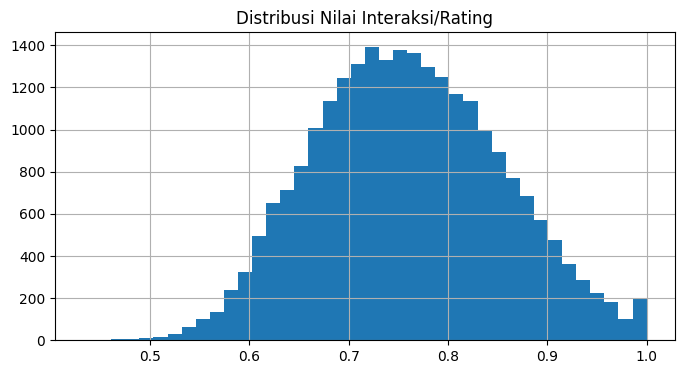

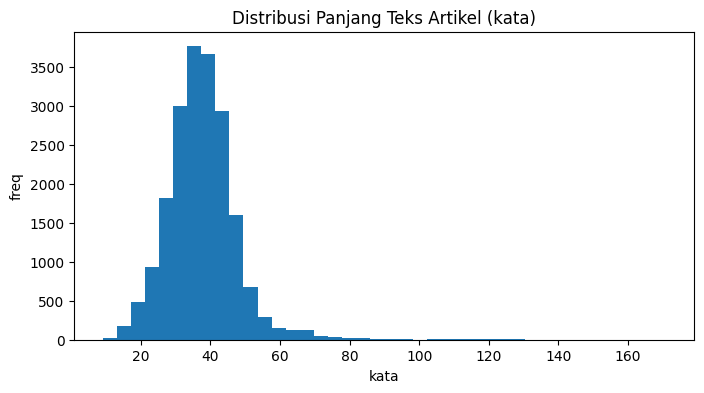

Top kategori:


,count
category,
Sports,5084
Sci/Tech,5003
World,4964
Business,4949


Artikel terpopuler (berdasarkan jumlah interaksi):


,count
article_id,
97439,7
9463,7
66050,7
73321,7
27647,7
13952,7
22333,6
62668,6
110205,6


Rata-rata interaksi per user: 24.387
Rata-rata interaksi per item: 1.7367184161800313


In [ ]:
#Type your code here

def topn(series, n=10):
    return series.value_counts().head(n).to_frame('count')

# 4.1 Cek missing values
print("Missing ratio items:")
display(articles.isna().mean().sort_values(ascending=False).to_frame("missing_ratio"))
print("Missing ratio interaksi:")
display(inter.isna().mean().sort_values(ascending=False).to_frame("missing_ratio"))

# 4.2 Ringkas struktur
n_users = inter[COL_USER].nunique()
n_items = inter[COL_ITEM_ID].nunique()
density = len(inter) / (n_users * n_items + 1e-9)

print(f"#User={n_users} | #Item={n_items} | Interaksi={len(inter)} | Sparsity≈{density:.6f}")

# 4.3 Distribusi skor/interaction
if pd.api.types.is_numeric_dtype(inter[COL_SCORE]):
    ax = inter[COL_SCORE].hist(bins=40)
    ax.set_title("Distribusi Nilai Interaksi/Rating"); plt.show()

# 4.4 Statistik artikel (panjang teks)
text_len = (articles.get(COL_TITLE, "").fillna('') + " " + articles.get(COL_CONTENT, "").fillna('')).str.split().map(len)
text_len.describe()

plt.hist(text_len, bins=40)
plt.title("Distribusi Panjang Teks Artikel (kata)"); plt.xlabel("kata"); plt.ylabel("freq")
plt.show()

# 4.5 Top kategori & artikel populer
if COL_CAT in articles.columns:
    print("Top kategori:")
    display(topn(articles[COL_CAT].fillna("unknown")))

print("Artikel terpopuler (berdasarkan jumlah interaksi):")
display(topn(inter[COL_ITEM_ID]))

# 4.6 Interaksi per user/item (hemat)
user_cnt = inter[COL_USER].value_counts()
item_cnt = inter[COL_ITEM_ID].value_counts()
print("Rata-rata interaksi per user:", user_cnt.mean())
print("Rata-rata interaksi per item:", item_cnt.mean())

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [ ]:
#Type your code here

# Output folder (sesuai syarat submission)
OUT_DIR = "/content/namadataset_preprocessing"
os.makedirs(OUT_DIR, exist_ok=True)

# 5.1 Normalisasi teks (judul + konten + kategori)
def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df_items = articles.copy()
df_inter = inter.copy()

# Gabungkan teks
df_items["text"] = (
    df_items.get(COL_TITLE, "").fillna('') + " " +
    df_items.get(COL_CONTENT, "").fillna('') + " " +
    (df_items.get(COL_CAT, "").fillna('') if COL_CAT in df_items.columns else "")
).map(normalize_text)

# 5.2 Hapus duplikat & tangani NA
df_items = df_items.drop_duplicates(subset=[COL_ITEM_ID]).dropna(subset=["text"])
df_inter = df_inter.dropna(subset=[COL_USER, COL_ITEM_ID, COL_SCORE])

# 5.3 Skala angka interaksi agar konsisten (0..1)
if pd.api.types.is_numeric_dtype(df_inter[COL_SCORE]):
    scaler = MinMaxScaler()
    df_inter["rating_scaled"] = scaler.fit_transform(df_inter[[COL_SCORE]])
else:
    # jika interaksi bukan numerik, ubah ke 1 (klik) sebagai sinyal implicit
    df_inter["rating_scaled"] = 1.0

# 5.4 Split train/valid untuk pemodelan berikutnya
train, valid = train_test_split(
    df_inter[[COL_USER, COL_ITEM_ID, "rating_scaled"]],
    test_size=0.2, random_state=42, shuffle=True
)

print("Train:", train.shape, " Valid:", valid.shape)

# 5.5 (Opsional) Vektorisasi TF-IDF awal (untuk sanity check CBF)
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)
X_tfidf = tfidf.fit_transform(df_items["text"])
print("Matriks TF-IDF:", X_tfidf.shape)

# 5.6 Simpan hasil preprocessing (WAJIB buat kriteria berikutnya)
items_out = df_items[[COL_ITEM_ID, COL_TITLE]].copy()
if COL_CAT in df_items.columns: items_out[COL_CAT] = df_items[COL_CAT]
items_out["text"] = df_items["text"]

items_out.to_csv(f"{OUT_DIR}/items_clean.csv", index=False)
train.to_csv(f"{OUT_DIR}/interactions_train.csv", index=False)
valid.to_csv(f"{OUT_DIR}/interactions_valid.csv", index=False)

print("✅ Preprocessing selesai & disimpan ke:", OUT_DIR)

# 5.7 Preview file keluaran
print("\nitems_clean.csv")
display(pd.read_csv(f"{OUT_DIR}/items_clean.csv").head())
print("\ninteractions_train.csv")
display(pd.read_csv(f"{OUT_DIR}/interactions_train.csv").head())
print("\ninteractions_valid.csv")
display(pd.read_csv(f"{OUT_DIR}/interactions_valid.csv").head())

Train: (19509, 3)  Valid: (4878, 3)
Matriks TF-IDF: (20000, 50000)
✅ Preprocessing selesai & disimpan ke: /content/namadataset_preprocessing

items_clean.csv


,article_id,title,category,text
0,71788,"BBC set for major shake-up, claims newspaper",Business,bbc set for major shake up claims newspaper lo...
1,67219,Marsh averts cash crunch,Business,marsh averts cash crunch embattled insurance b...
2,54067,"Jeter, Yankees Look to Take Control (AP)",Sports,jeter yankees look to take control ap ap derek...
3,7169,Flying the Sun to Safety,Sci/Tech,flying the sun to safety when the genesis caps...
4,29619,Stocks Seen Flat as Nortel and Oil Weigh,Business,stocks seen flat as nortel and oil weigh new y...



interactions_train.csv


,user_id,article_id,rating_scaled
0,623,64421,0.443239
1,565,20691,0.783831
2,305,73422,0.482981
3,885,87106,0.651627
4,906,12270,0.642139



interactions_valid.csv


,user_id,article_id,rating_scaled
0,856,24234,0.492692
1,438,11187,0.514358
2,600,33852,0.687710
3,927,81812,0.348869
4,564,77720,0.603308
